In [16]:
import json
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from pathlib import Path
from typing import List, Dict, Any



# 設定繪圖風格
sns.set(style="whitegrid")
%matplotlib inline

def entropy_from_counts(counts: Counter) -> float:
    total = sum(counts.values())
    if total == 0: return 0.0
    H = 0.0
    for c in counts.values():
        p = c / total
        H -= p * math.log2(p)
    return H

def load_cases_from_file(path: Path, option_label: str) -> List[Dict[str, Any]]:
    if not path.is_file():
        print(f"[WARN] 找不到檔案: {path}")
        return []
    with path.open("r", encoding="utf-8") as f:
        data = json.load(f)
    for rec in data:
        rec["option"] = option_label
        rec["source_file"] = str(path)
    return data

In [13]:
# 根據你的環境調整 base_path
# 如果你的 .ipynb 就在 experment/tool 目錄下：
base_path = Path("../..") 

DEFAULT_FILES = {
    "op1_case1": "option_1/json/processed/op1_100_case_1.json",
    "op1_case2": "option_1/json/processed/op1_100_case_2.json",
    "op2_case1": "option_2/json/processed/op2_100_case_1.json",
    "op2_case2": "option_2/json/processed/op2_100_case_2.json",
}

records = []
for name, rel_path in DEFAULT_FILES.items():
    opt = "op1" if "op1" in name else "op2"
    full_path = base_path / rel_path
    records.extend(load_cases_from_file(full_path, opt))

df = pd.DataFrame.from_records(records)
df["error_type"] = df["error_type"].fillna("unknown")
df["modified_key"] = df["modified_key"].fillna("unknown")

print(f"成功載入 {len(df)} 筆數據。")
df.head()

成功載入 400 筆數據。


,filename,modified_key,original_value,error_value,error_type,affected_module,impact_description,option,source_file
0,DU_case_001.json,gNBs[0].pdsch_AntennaPorts_XP,2,8,out of range,PHY,Exceeds maximum supported antenna ports for PDSCH,op1,..\..\option_1\json\processed\op1_100_case_1.json
1,DU_case_002.json,gNBs[0].pdsch_AntennaPorts_N1,2,1,invalid enum,PHY,Invalid antenna port configuration for PDSCH,op1,..\..\option_1\json\processed\op1_100_case_1.json
2,DU_case_003.json,gNBs[0].servingCellConfigCommon[0].dl_frequenc...,78,79,out of range,RRC,Invalid frequency band for serving cell,op1,..\..\option_1\json\processed\op1_100_case_1.json
3,DU_case_004.json,gNBs[0].servingCellConfigCommon[0].dl_subcarri...,1,3,invalid enum,RRC,Invalid subcarrier spacing for serving cell,op1,..\..\option_1\json\processed\op1_100_case_1.json
4,DU_case_005.json,gNBs[0].servingCellConfigCommon[0].initialDLBW...,28875,30000,out of range,RRC,Exceeds maximum supported bandwidth for DL BWP,op1,..\..\option_1\json\processed\op1_100_case_1.json


In [17]:
summary_rows = []
detail_counts = []

# 為了歸一化，取得全域的類別與參數總量
total_et_k = len(df["error_type"].unique())
df["simplified_key"] = df["modified_key"].str.replace(r"\[\d+\]", "", regex=True)
total_mk_k = len(df["simplified_key"].unique())

for opt, g in df.groupby("option"):
    # 1. Error Type 分析
    et_counts = Counter(g["error_type"])
    et_entropy = entropy_from_counts(et_counts)
    # 使用全域總量進行歸一化
    et_norm = et_entropy / math.log2(total_et_k) if total_et_k > 1 else 0.0

    # 2. Modified Key 分析
    mk_counts = Counter(g["simplified_key"])
    mk_entropy = entropy_from_counts(mk_counts)
    # 使用全域參數總量進行歸一化
    mk_norm = mk_entropy / math.log2(total_mk_k) if total_mk_k > 1 else 0.0

    # 封裝結果，新增原始熵值欄位
    summary_rows.append({
        "option": opt,
        "num_cases": len(g),
        "error_type_entropy": round(et_entropy, 4),
        "error_type_norm_entropy": round(et_norm, 4),
        "param_coverage_entropy": round(mk_entropy, 4),
        "param_coverage_norm_entropy": round(mk_norm, 4),
        "unique_params_tested": len(mk_counts)
    })
    
    for k, count in mk_counts.items():
        detail_counts.append({"option": opt, "param": k, "count": count})

# 建立 DataFrame
summary_df = pd.DataFrame(summary_rows)
param_counts_df = pd.DataFrame(detail_counts)

# 顯示結果
summary_df

,option,num_cases,error_type_entropy,error_type_norm_entropy,param_coverage_entropy,param_coverage_norm_entropy,unique_params_tested
0,op1,200,1.6832,0.6512,6.5435,0.9425,99
1,op2,200,2.1194,0.8199,6.5203,0.9392,101


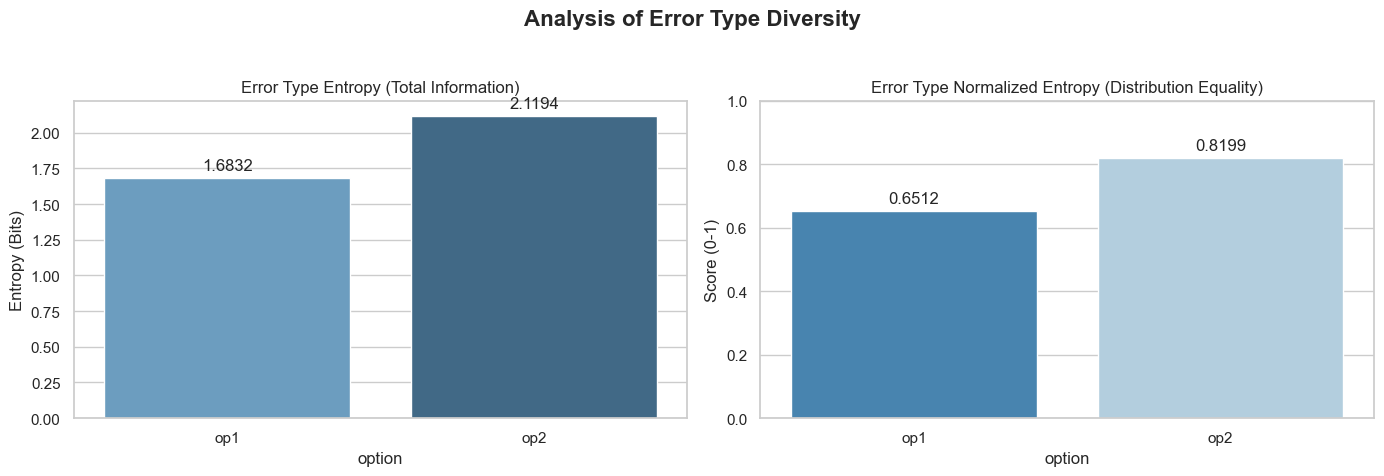

In [24]:
# --- 直接從 summary_df 讀取數據，不再手寫 ---
# 這樣如果你的 JSON 資料更新了，圖表也會同步更新
df_to_plot = summary_df.copy()

sns.set(style="whitegrid")

# --- 第一張圖：Error Type 多樣性分析 ---
fig1, ax1 = plt.subplots(1, 2, figsize=(14, 5))
fig1.suptitle('Analysis of Error Type Diversity', fontsize=16, fontweight='bold')

# 左圖：Error Type 原始熵值
sns.barplot(data=df_to_plot, x="option", y="error_type_entropy", hue="option", 
            ax=ax1[0], palette="Blues_d", legend=False)
ax1[0].set_title("Error Type Entropy (Total Information)")
ax1[0].set_ylabel("Entropy (Bits)")

# 右圖：Error Type 歸一化熵值
sns.barplot(data=df_to_plot, x="option", y="error_type_norm_entropy", hue="option", 
            ax=ax1[1], palette="Blues_r", legend=False)
ax1[1].set_ylim(0, 1.0)
ax1[1].set_title("Error Type Normalized Entropy (Distribution Equality)")
ax1[1].set_ylabel("Score (0-1)")

# 數值標註
for a in ax1:
    for p in a.patches:
        a.annotate(format(p.get_height(), '.4f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha='center', va='center', xytext=(0, 9), textcoords='offset points')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

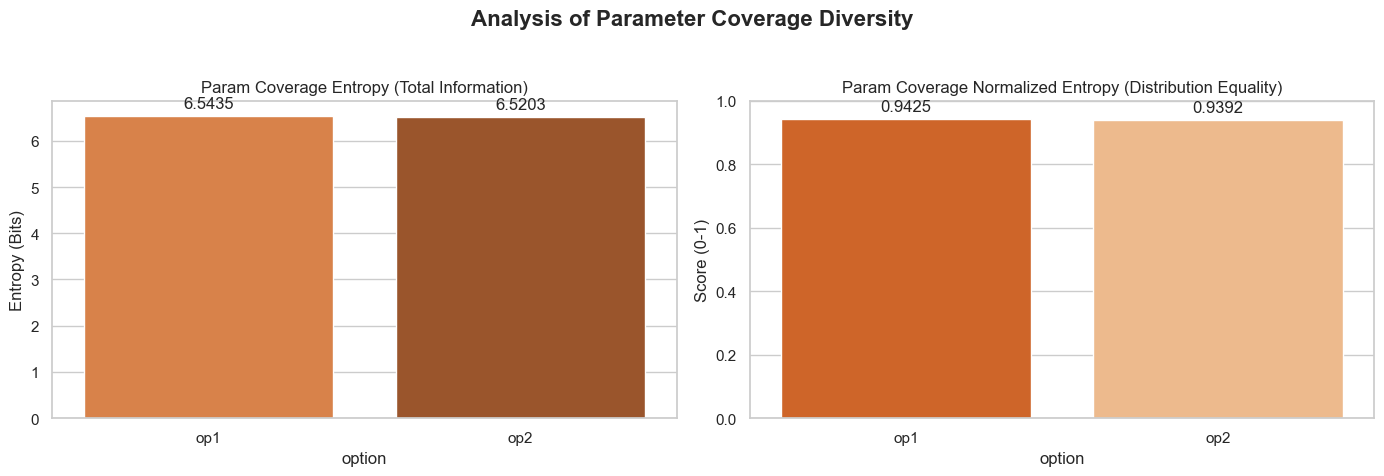

In [23]:

# --- 第二張圖：Parameter Coverage 多樣性分析 ---
fig2, ax2 = plt.subplots(1, 2, figsize=(14, 5))
fig2.suptitle('Analysis of Parameter Coverage Diversity', fontsize=16, fontweight='bold')

# 左圖：參數覆蓋原始熵值
sns.barplot(data=df_to_plot, x="option", y="param_coverage_entropy", hue="option", 
            ax=ax2[0], palette="Oranges_d", legend=False)
ax2[0].set_title("Param Coverage Entropy (Total Information)")
ax2[0].set_ylabel("Entropy (Bits)")

# 右圖：參數覆蓋歸一化熵值
sns.barplot(data=df_to_plot, x="option", y="param_coverage_norm_entropy", hue="option", 
            ax=ax2[1], palette="Oranges_r", legend=False)
ax2[1].set_ylim(0, 1.0)
ax2[1].set_title("Param Coverage Normalized Entropy (Distribution Equality)")
ax2[1].set_ylabel("Score (0-1)")

# 數值標註
for a in ax2:
    for p in a.patches:
        a.annotate(format(p.get_height(), '.4f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha='center', va='center', xytext=(0, 9), textcoords='offset points')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [10]:
out_dir = Path("./result")
out_dir.mkdir(parents=True, exist_ok=True)

summary_df.to_csv(out_dir / "diversity_analysis_summary.csv", index=False)
param_counts_df.to_csv(out_dir / "param_usage_counts.csv", index=False)

print(f"結果已存儲於 {out_dir} 目錄下。")

結果已存儲於 result 目錄下。
